# Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go

from scripts import Datax18, NARXx18



device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Using device: {device}")

Using device: mps


# Data preprocessing

Data Format Description in SN_ms_tot_V2.0.csv:

| Column(s) | Name | Description |
|-----------|------|-------------|
| 1-2 | Calendar Date | **Year** (YYYY) and **Month** (MM) in egorian calendar |
| 3 | Decimal Date | Date as fraction of year (YYYY.fff) |
| 4 | Sunspot Number | Monthly smoothed total sunspot count |
| 5 | Standard Deviation | Monthly mean std. dev. of input asurements |
| 6 | Sample Size | Number of observations used for monthly mean |
| 7 | Status | Data validation flag: |
|   |        | • 1 = Definitive (final) value |
|   |        | • 0 = Provisional value |



In [18]:
df_theoretical = pd.read_csv('data/theoretical_series.csv', sep=';')
df_theoretical

,decimal_date,T1,T2,T3,T4,T5
0,1964.290000,6.238113,1.358705,8.952250,20.055768,15.689878
1,1964.373000,6.552118,1.509507,9.384701,20.675201,14.810065
2,1964.456000,6.888593,1.682225,9.867576,21.396530,14.318844
3,1964.540000,7.252599,1.858949,10.374440,22.039826,14.351114
4,1964.624000,7.667502,2.059977,10.954735,22.754826,14.813335
...,...,...,...,...,...,...
849,2035.039667,69.618968,110.107073,28.882009,135.716777,146.994017
850,2035.123000,75.885278,114.582486,30.671043,138.589157,149.402212
851,2035.206333,82.070992,118.824089,32.538707,141.274664,151.558947
852,2035.289667,88.125722,122.809352,34.313209,143.648229,153.460878


In [19]:
df_ssn = pd.read_csv(
    'data/SN_ms_tot_V2.0.csv',
    sep=';',
    header=None,
    names=['Year', 'Month', 'Decimal Date', 'SSN', 'Std Dev', 'Obs', 'Def'],
)
df_ssn = df_ssn[['Decimal Date', 'SSN']]
df_ssn 

,Decimal Date,SSN
0,1964.290,18.6
1,1964.373,16.0
2,1964.456,15.0
3,1964.540,15.2
4,1964.624,15.1
...,...,...
733,2025.371,-1.0
734,2025.453,-1.0
735,2025.538,-1.0
736,2025.623,-1.0


Match the decimal date in df_theoretical with the decimal date in df_ssn

In [20]:
df_ssn = df_ssn[df_ssn['Decimal Date'] >= df_theoretical['decimal_date'].iloc[0]]

df_ssn = df_ssn[df_ssn['SSN'].shift(1) != -1]

df_ssn = df_ssn.reset_index(drop=True)
df_ssn


,Decimal Date,SSN
0,1964.290,18.6
1,1964.373,16.0
2,1964.456,15.0
3,1964.540,15.2
4,1964.624,15.1
...,...,...
728,2024.958,151.2
729,2025.042,146.2
730,2025.122,139.8
731,2025.204,135.9


In [21]:
theoretical_series = df_theoretical['T1'].values
observed_series = df_ssn['SSN'].values

theoretical_series.shape, observed_series.shape

((854,), (733,))

In [22]:
prev_values = 4
horizon = 18
data = Datax18(theoretical_series, observed_series, prev_values, horizon)

In [23]:
print(data.X[0])
print(data.y[0])
print(data.X[-1])
print(data.y[-1])

print(data.X.shape)
print(data.y.shape)


tensor([ 6.2381,  6.5521,  6.8886,  7.2526,  7.6675,  8.1085,  8.5509,  9.0527,
         9.6095, 10.2175, 10.8941, 11.5831, 12.3269, 13.1797, 14.1111, 15.0880,
        16.2089, 17.3378, 18.6209, 20.0790, 21.6504, 23.3132, 18.6000, 16.0000,
        15.0000, 15.2000])
tensor(39.7000)
tensor([128.7271, 131.6180, 134.3703, 136.9060, 139.2164, 141.3179, 143.2396,
        144.9878, 146.5429, 147.9763, 149.2225, 150.2702, 151.1274, 151.7974,
        152.2834, 152.6333, 152.8338, 152.8685, 152.7391, 152.4658, 152.0881,
        151.5808, 124.6000, 124.3000, 124.0000, 124.8000])
tensor(-1.)
torch.Size([712, 26])
torch.Size([712])


In [24]:
train_data_X = data.X[:722 + 1 - (horizon - 1) - prev_values]
train_data_y = data.y[:722 + 1 - (horizon - 1) - prev_values]
train_data_X.shape, train_data_y.shape, data.X.shape, data.y.shape

(torch.Size([702, 26]),
 torch.Size([702]),
 torch.Size([712, 26]),
 torch.Size([712]))

In [25]:
test_data_X = data.X[722 + 1 - (horizon - 1) - prev_values:]
test_data_y = data.y[722 + 1 - (horizon - 1) - prev_values:]

In [26]:
test_data_X, test_data_y

(tensor([[ 93.6175,  98.2260, 102.6996, 106.9758, 111.0381, 114.9452, 118.7616,
          122.3247, 125.6474, 128.7271, 131.6180, 134.3703, 136.9060, 139.2164,
          141.3179, 143.2396, 144.9878, 146.5429, 147.9763, 149.2225, 150.2702,
          151.1274,  98.9000, 101.2000, 106.7000, 113.3000],
         [ 98.2260, 102.6996, 106.9758, 111.0381, 114.9452, 118.7616, 122.3247,
          125.6474, 128.7271, 131.6180, 134.3703, 136.9060, 139.2164, 141.3179,
          143.2396, 144.9878, 146.5429, 147.9763, 149.2225, 150.2702, 151.1274,
          151.7974, 101.2000, 106.7000, 113.3000, 117.8000],
         [102.6996, 106.9758, 111.0381, 114.9452, 118.7616, 122.3247, 125.6474,
          128.7271, 131.6180, 134.3703, 136.9060, 139.2164, 141.3179, 143.2396,
          144.9878, 146.5429, 147.9763, 149.2225, 150.2702, 151.1274, 151.7974,
          152.2834, 106.7000, 113.3000, 117.8000, 121.1000],
         [106.9758, 111.0381, 114.9452, 118.7616, 122.3247, 125.6474, 128.7271,
          131.618

In [27]:
M = np.max(observed_series)
observed_series = observed_series / M
theoretical_series = theoretical_series / M

In [28]:
path_to_models = 'weights_and_data/real_model/real_model_new/0/'

predictions = []



for horizon in range (1, 19):
    model = NARXx18(2 * 4 + horizon, [24], 1, M)
    model.load_state_dict(torch.load(
        os.path.join(path_to_models, f'model_weights_horizon{horizon}.pth'),
        map_location=torch.device('mps')
    ))
    data = Datax18(theoretical_series, observed_series, 4, horizon)
    # test_data_X = data.X[722 + 1 - (horizon - 1) - 4:]
    test_data_X = data.X[722 + 1 - (horizon - 1) - 4 + 7:]
    test_data_X = test_data_X.to(device)
    model = model.to(device)
    res = model(test_data_X).squeeze()
    res = res.cpu().detach().numpy()
    res = res * M
    predictions.append(res)
    
predictions = np.array(predictions)
    


In [29]:
predictions.T.shape

(3, 18)

In [33]:


import datetime


In [ ]:

import datetime
from dateutil.relativedelta import relativedelta

start_month = 7
start_year = 2024  # Use full year here
start_date = datetime.datetime(start_year, start_month, 1) 
date = start_date + relativedelta(months=6)

# Создаем файлы CSV
for i in range(7):
    year, month = date.year, date.month
    file_name = f"R_{year}_{str(month).zfill(2)}.txt"
    with open(file_name, "w") as file:
        for j in range(18):
            file.write(f"{predictions.T[i][j]}\n")
    date += relativedelta(months=1)
    

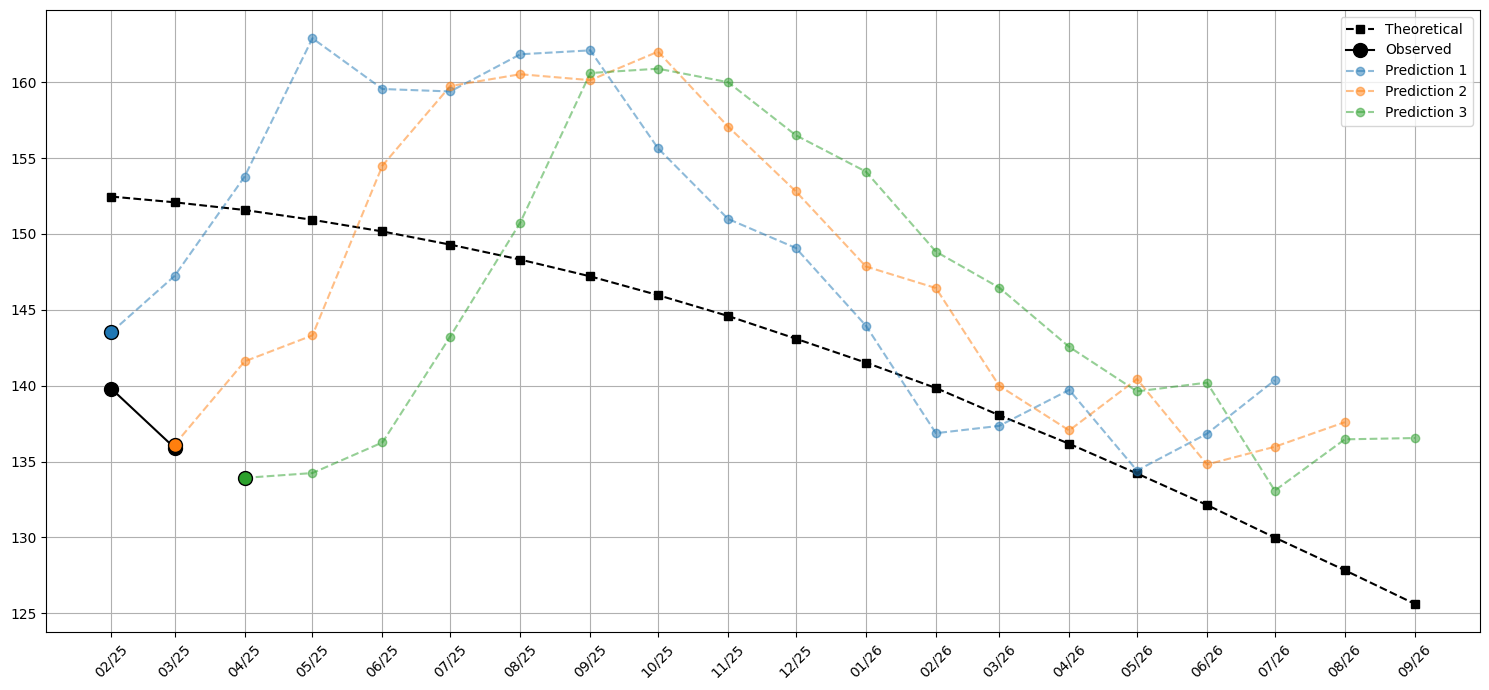

In [34]:
import seaborn as sns
import matplotlib.dates as mdates

def decimal_to_datetime(decimal_date):
    year = int(decimal_date)
    rem = decimal_date - year
    month = int(rem * 12) + 1
    # Handle edge case where rem*12 is very close to 12 (e.g., 2024.9999)
    if month > 12:
        year += 1
        month = 1
    return datetime.datetime(year, month, 1)

plt.figure(figsize=(15, 7))
obs_n = len(observed_series)
n = 3
first_date = df_ssn['Decimal Date'].iloc[obs_n - n]

# Convert decimal dates to datetime for x-axis
theoretical_x = [decimal_to_datetime(dd) for dd in df_theoretical['decimal_date'][obs_n - n:obs_n + 18 - 1]]
observed_x = [decimal_to_datetime(dd) for dd in df_ssn['Decimal Date'][-n:-1]]

plt.plot(
    theoretical_x,
    theoretical_series[obs_n - n:obs_n + 18 - 1] * M,
    label='Theoretical',
    marker='s',
    linestyle='--',
    color='black'
)

plt.plot(
    observed_x,
    observed_series[-n:-1] * M,
    label='Observed',
    marker='o',
    markersize=10,
    color='black'
)

for i, pred in enumerate(predictions.T):
    pred_x = [decimal_to_datetime(dd) for dd in df_theoretical['decimal_date'][obs_n - n + i:obs_n - n + i + 18]]
    # Plot all points except the first
    plt.plot(
        pred_x,
        pred,
        label=f'Prediction {i+1}',
        linestyle='--',
        marker='o',
        alpha=0.5
    )
    # Make the first plotted value bigger
    plt.scatter(
        pred_x[0],
        pred[0],
        s=100,  # size of the marker
        color=plt.gca().lines[-1].get_color(),  # match line color
        edgecolor='black',
        zorder=5
    )

# Format x-axis as m/y
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import numpy as np
import os
import pandas as pd

# Save every prediction to file predict_25_01 and so on
# predictions: shape (n_predictions, n_steps)
# We'll save each prediction as a CSV with columns: year, month, value

output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

for i, pred in enumerate(predictions.T):
    # Get the corresponding decimal dates for this prediction
    pred_decimal_dates = df_theoretical['decimal_date'][obs_n - n + i:obs_n - n + i + 18].values
    # Convert decimal dates to year and month as int
    years = np.floor(pred_decimal_dates).astype(int)
    months = np.round((pred_decimal_dates - years) * 12 + 1).astype(int)
    # Fix months that round to 13
    months[months == 13] = 12
    # Create DataFrame without column names, year and month as int
    df_out = pd.DataFrame({
        0: (years % 2000).astype(int),
        1: months.astype(int),
        2: pred
    })
    filename = os.path.join(output_dir, f"predict_25_{i+1 + 7:02d}.csv")
    df_out.to_csv(filename, index=False, header=False)


In [98]:
years

array([2024, 2024, 2024, 2024, 2024, 2024, 2025, 2025, 2025, 2025, 2025,
       2025, 2025, 2025, 2025, 2025, 2025, 2025])

In [ ]:
def load_ssn_data(ur

In [30]:
url = "https://www.sidc.be/SILSO/DATA/SN_ms_tot_V2.0.csv"
df_ssn = pd.read_csv(url, sep=';', header=None, names=['Year', 'Month', 'Decimal Date', 'SSN', 'Std Dev', 'Obs', 'Def'])
df_ssn

,Year,Month,Decimal Date,SSN,Std Dev,Obs,Def
0,1749,1,1749.042,-1.0,-1.0,-1,1
1,1749,2,1749.123,-1.0,-1.0,-1,1
2,1749,3,1749.204,-1.0,-1.0,-1,1
3,1749,4,1749.288,-1.0,-1.0,-1,1
4,1749,5,1749.371,-1.0,-1.0,-1,1
...,...,...,...,...,...,...,...
3316,2025,5,2025.371,-1.0,-1.0,1225,0
3317,2025,6,2025.453,-1.0,-1.0,1231,0
3318,2025,7,2025.538,-1.0,-1.0,1145,0
3319,2025,8,2025.623,-1.0,-1.0,1114,0


In [31]:
df_theoretical = pd.read_csv('data/theoretical_series.csv', sep=';')
df_ssn = df_ssn[df_ssn['Decimal Date'] >= df_theoretical['decimal_date'].iloc[0]].reset_index(drop=True)
df_ssn = df_ssn[df_ssn['SSN'].shift(1) != -1]
df_ssn

,Year,Month,Decimal Date,SSN,Std Dev,Obs,Def
0,1964,4,1964.290,18.6,2.9,30,1
1,1964,5,1964.373,16.0,2.7,31,1
2,1964,6,1964.456,15.0,2.6,30,1
3,1964,7,1964.540,15.2,2.7,31,1
4,1964,8,1964.624,15.1,2.6,31,1
...,...,...,...,...,...,...,...
728,2024,12,2024.958,151.2,21.3,653,1
729,2025,1,2025.042,146.2,20.8,772,0
730,2025,2,2025.122,139.8,20.2,791,0
731,2025,3,2025.204,135.9,19.8,1136,0


In [32]:
df_ssn = df_ssn[['Decimal Date', 'SSN']]
df_ssn


,Decimal Date,SSN
0,1964.290,18.6
1,1964.373,16.0
2,1964.456,15.0
3,1964.540,15.2
4,1964.624,15.1
...,...,...
728,2024.958,151.2
729,2025.042,146.2
730,2025.122,139.8
731,2025.204,135.9


In [33]:
df_theoretical

,decimal_date,T1,T2,T3,T4,T5
0,1964.290000,6.238113,1.358705,8.952250,20.055768,15.689878
1,1964.373000,6.552118,1.509507,9.384701,20.675201,14.810065
2,1964.456000,6.888593,1.682225,9.867576,21.396530,14.318844
3,1964.540000,7.252599,1.858949,10.374440,22.039826,14.351114
4,1964.624000,7.667502,2.059977,10.954735,22.754826,14.813335
...,...,...,...,...,...,...
849,2035.039667,69.618968,110.107073,28.882009,135.716777,146.994017
850,2035.123000,75.885278,114.582486,30.671043,138.589157,149.402212
851,2035.206333,82.070992,118.824089,32.538707,141.274664,151.558947
852,2035.289667,88.125722,122.809352,34.313209,143.648229,153.460878


In [34]:
theoretical_series = df_theoretical['T1'].values
observed_series = df_ssn['SSN'].values

prev_values = 4
horizon = 18
data = Datax18(theoretical_series, observed_series, prev_values, horizon)

In [35]:
theoretical_series.shape, observed_series.shape

((854,), (733,))

In [36]:
M = np.max(observed_series)
observed_series = observed_series / M
theoretical_series = theoretical_series / M
path_to_models = 'weights_and_data/real_model/real_model_new/0/'

predictions = []




In [37]:

for horizon in range (1, 19):
    model = NARXx18(2 * 4 + horizon, [24], 1, M)
    model.load_state_dict(torch.load(
        os.path.join(path_to_models, f'model_weights_horizon{horizon}.pth'),
        map_location=torch.device('mps')
    ))
    data = Datax18(theoretical_series, observed_series, 4, horizon)
    # test_data_X = data.X[722 + 1 - (horizon - 1) - 4:]
    test_data_X = data.X[722 + 1 - (horizon - 1) - 4 + 7:]
    test_data_X = test_data_X.to(device)
    model = model.to(device)
    res = model(test_data_X).squeeze()
    res = res.cpu().detach().numpy()
    res = res * M
    predictions.append(res)
    
predictions = np.array(predictions)
    
